In [16]:
# | default_exp models

# A Bayesian GARCH-Inspired Volatility Model for Energy Commodities Option Pricing

## TLDR

I built a Bayesian GARCH-like model for heating oil prices using NumPyro. Here’s the full messy journey. Also, as if it was not clear, never ever attempt to use it for anything practical - this will not end well, so not a financial advice :D

## Introduction

I’ve been interested in financial markets for a while, especially the modeling failures surrounding the 2008 financial crisis. One recurring theme is how standard models struggled to capture risk during volatile periods. That led me to explore financial modeling more seriously, starting with option pricing as a fundamental use case.

While it’s easy enough to plug numbers into Black-Scholes, I wanted to build something from the ground up—specifically a model that learns volatility structure directly from data. So I built a GARCH-inspired, fully Bayesian model using NumPyro that captures both return and variance dynamics.

This post walks through that process: loading and transforming market data, fitting the model, simulating future prices, and estimating option payoffs. It’s a basic framework, but a flexible one, and I’ve also started thinking about ways to extend it—for example, conditioning on storage levels data.

Using the model’s generative structure, I simulated forward price paths and estimated call option payoffs at expiration. From these, I computed the likelihood of finishing in the money, and compared the expected payoff to the cost of the option. If the average payoff exceeds the premium, it suggests a positive expected value—at least under the model’s assumptions.

For now, this assumes European-style options and a buy-and-hold strategy to maturity. The underlying commodity we are targeting is[ Heating Oil](https://uk.investing.com/commodities/heating-oil).

## Data loading process

We start by loading the data, and examining the returns, log-return distribution, as well as variance plots. The dataset we are using today contains heating oil prices from 2010 until May, 2025. The dataset was pulled from [investing.com](https://uk.investing.com/commodities/heating-oil).

In [17]:
# | exporti


import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from tqdm import tqdm
from bayesianfin.simulation import Simulator
from bayesianfin.data import (
    QuantileTransformer,
    DataLoader,
    FeatureEngineer,
    LogReturn,
    Variance,
    Identity,
)

In [18]:
# | export
az.style.use("arviz-darkgrid")

In [19]:
source_df = (
    pl.read_csv(
        "./data/heating_oil.csv",
        infer_schema_length=0,
        dtypes={"Price": pl.Utf8},
        columns=["Date", "Price"],
    )
    .with_columns(
        pl.col("Date").str.to_date(format="%m/%d/%Y"),
        pl.col("Price").str.replace_all(",", "").cast(pl.Float64),
    )
    .rename({"Date": "date", "Price": "price"})
    .with_columns(
        ret=pl.col("price") / pl.col("price").shift(1),
    )
).sort("date")
source_df

/var/folders/8s/q13s1_m56g3b3k_1fmdrwn_80000gn/T/ipykernel_85699/3357814223.py:2: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  pl.read_csv(


date,price,ret
date,f64,f64
2010-04-05,2.2825,0.998775
2010-04-06,2.2853,1.010703
2010-04-07,2.2611,1.007396
2010-04-08,2.2445,1.000401
2010-04-09,2.2436,1.002771
…,…,…
2025-04-28,2.1755,1.025986
2025-04-29,2.1204,1.041096
2025-04-30,2.0367,1.015608


The class below is implemented to ease off the data analysis and handling. It produces lagged features for returns and variances, as well as transforms the data so it is easier to feed into a model.

In [20]:
# | exec: false
feature_engineer = FeatureEngineer(
    transforms=[
        LogReturn(source_field="ret", feature_name="log_ret"),
        Variance(
            source_field="price",
            feature_name="var",
            rolling_variance_window=2,
        ),
        QuantileTransformer(source_field="var", feature_name="var_quantile"),
    ],
    n_shifts=3,
)
df_with_features = feature_engineer.create_features(source_df)
df_with_features.head()

date,price,ret,log_ret,var,var_quantile,prev_log_ret_1,prev_log_ret_2,prev_log_ret_3,prev_var_1,prev_var_2,prev_var_3,prev_var_quantile_1,prev_var_quantile_2,prev_var_quantile_3
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-04-09,2.2436,1.002771,0.002767,0.0001,0.0,0.000401,0.007369,0.010646,0.000138,0.000293,0.0001,0.388388,0.53155,0.0
2010-04-12,2.2374,1.001791,0.001789,0.0001,0.0,0.002767,0.000401,0.007369,0.0001,0.000138,0.000293,0.0,0.388388,0.53155
2010-04-13,2.2334,0.987531,-0.012547,0.0001,0.0,0.001789,0.002767,0.000401,0.0001,0.0001,0.000138,0.0,0.0,0.388388
2010-04-14,2.2616,0.994591,-0.005424,0.000398,0.596285,-0.012547,0.001789,0.002767,0.0001,0.0001,0.0001,0.0,0.0,0.0
2010-04-15,2.2739,1.015406,0.015288,0.0001,0.0,-0.005424,-0.012547,0.001789,0.000398,0.0001,0.0001,0.596285,0.0,0.0


## Exploratory data analysis

Let's look at various dynamics and distributions associated with this dataset. The first thing we notice is that neither return nor their log counterparts are distributed normally. Instead we see very narrow shapes with random variables that are sufficiently sub-gaussian. From my reading online it is quite normal for commodities, especially heating oil.

(-1.0, 2.0)

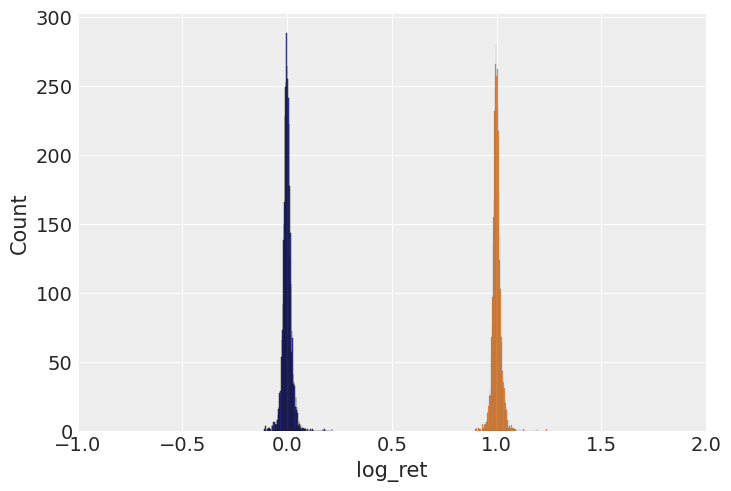

In [21]:
sns.histplot(df_with_features, x="log_ret")
sns.histplot(df_with_features, x="ret")
plt.xlim([-1, 2])

The 3-day lag variance dynamics are plotted below. As we can see the variance has periods of massive volatility.

<Axes: xlabel='date', ylabel='log_ret'>

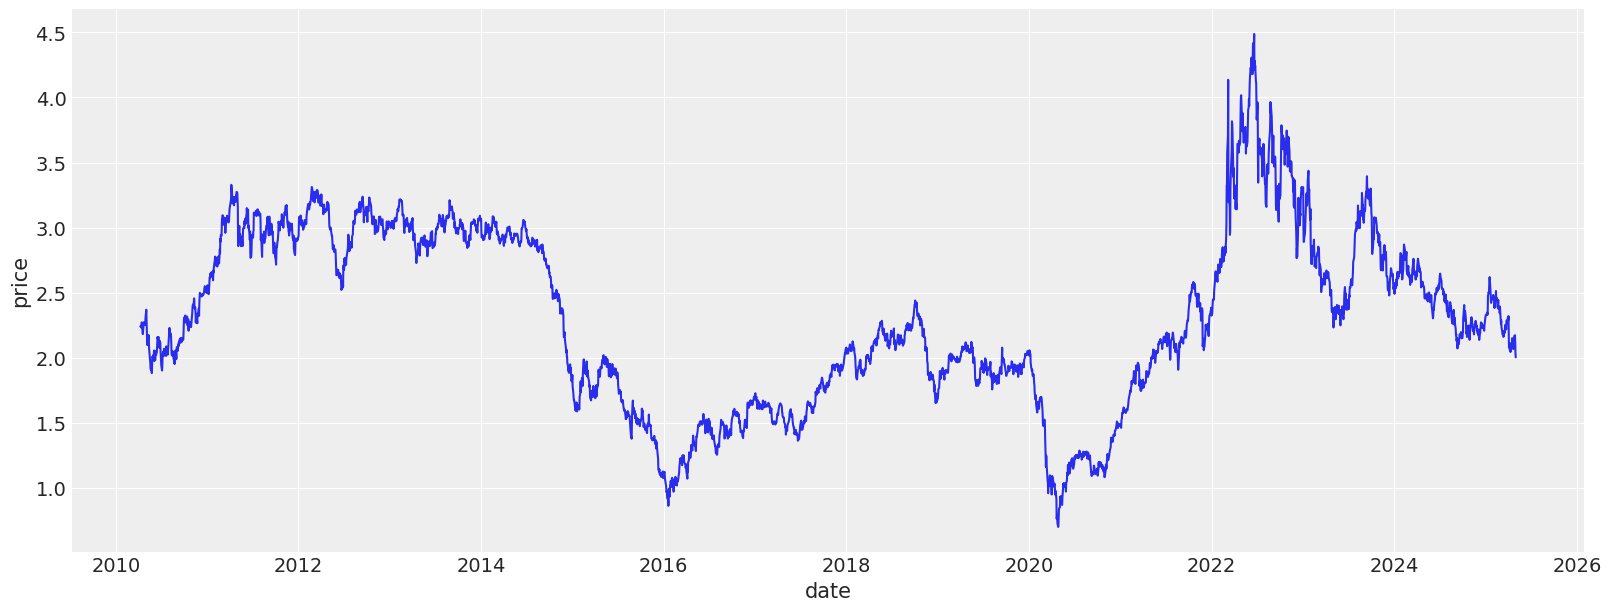

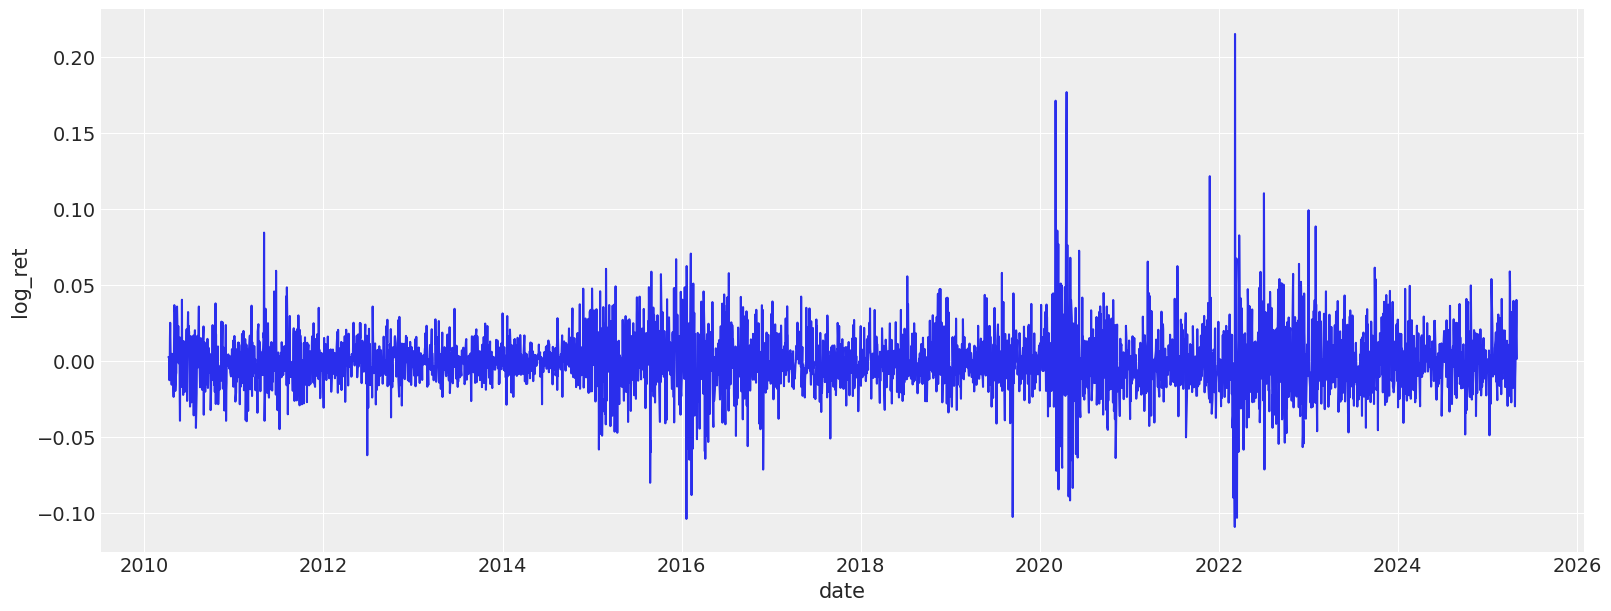

In [22]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_with_features, x="date", y="price")
plt.figure(figsize=(16, 6))
sns.lineplot(df_with_features, x="date", y="log_ret")

## The model

I decided to go for the following process of modelling the log returns:

$$
\begin{align*}
\log r_t &\sim \mathcal{N}(0, \sigma_t^2) \\
\sigma_t^2 &= \beta_0 + \sum_{i=1}^S \beta_i \sigma_{t-i}^2
\end{align*}
$$

While this model does not properly model the variance the way a ARCH/GARCH model would, I'm going to go with it for the sake of this learning exercise. Note that the mean for this model is fixed and set to 0. The reason for this is that it's a well known property of log returns to be dead centered around 0, so the only thing that matter is the volatility we are trying to predict.

 It is also worth mentioning that there is a conceptual gap between me using the dataset variance for learning and later generating variance myself and essentially continuing in an autoregressive manner. While true, it's practically a workable approach and used widely in other fields of ML, e.g. trajectory prediction with generative models. One of the next things I'm intending to do is to consider volatility to be latent variable and sample it myself, conditioning the site on observed volatility at the time. When it is not observed, it will just be sampled during the generative phase. In a way, we use variance as a noisy estimate of the latent variance, which, again, not how things are done properly, but that is a story for an upcoming article.

In [23]:
# Cut-off point
T = 300
present_value_train, present_value_test = (
    df_with_features["log_ret"][:-T].to_numpy(),
    df_with_features["log_ret"][-T:].to_numpy(),
)
past_values_train, past_values_test = (
    feature_engineer.to_numpy_dict(df_with_features[:-T]),
    feature_engineer.to_numpy_dict(df_with_features[-T:]),
)

In [24]:
# | export
def garch_like_model(
    present_value: npt.NDArray = None, past_values: dict[str, npt.NDArray] = None
) -> None:
    b_var = numpyro.sample("b_var", dist.Normal(0.0, 0.3))  # So it is positive

    coeffs = {}
    for col, s in feature_engineer.get_iterator("var_quantile"):
        param_name = feature_engineer.get_shift_pattern(col, s)
        coeffs[param_name] = numpyro.sample(f"param_{param_name}", dist.Exponential(50))

    # Handle prediction case
    len_observations = len(present_value) if present_value is not None else 1
    with numpyro.plate("data", len_observations):
        mu_var = b_var
        for col, s in feature_engineer.get_iterator("var_quantile"):
            param_name = feature_engineer.get_shift_pattern(col, s)
            mu_var += coeffs[param_name] * past_values[param_name]

    df = numpyro.sample("df", dist.Exponential(10.0))  # degrees of freedom, >2
    numpyro.sample("log_ret", dist.StudentT(df, 0, jnp.sqrt(mu_var)), obs=present_value)

Here’s a visualization of the model structure to clarify the dependencies.

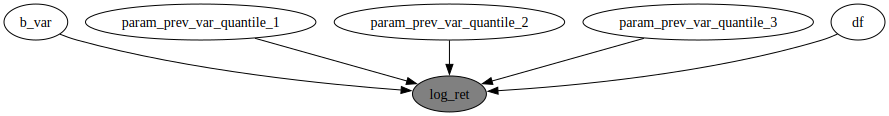

In [25]:
numpyro.render_model(
    garch_like_model,
    model_args=(
        present_value_train,
        past_values_train,
    ),
)

The model is fitted using MCMC with the NUTS sampler.

In [26]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(garch_like_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

mcmc.run(
    rng_key_,
    present_value=present_value_train,
    past_values=past_values_train,
)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [01:05<00:00, 46.15it/s, 1023 steps of size 1.73e-03. acc. prob=0.94]


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                      b_var      0.00      0.00      0.00      0.00      0.00    591.50      1.00
                         df      3.47      0.20      3.47      3.14      3.78    303.25      1.00
  param_prev_var_quantile_1      0.00      0.00      0.00      0.00      0.00    693.25      1.00
  param_prev_var_quantile_2      0.00      0.00      0.00      0.00      0.00    384.13      1.00
  param_prev_var_quantile_3      0.00      0.00      0.00      0.00      0.00    282.60      1.00

Number of divergences: 0


With the model converged to good values, with great values for $\hat{r}$, we should take a look at Bayesian factors. In this case we realise that for the volatility regression coefficients, we get values well above 1, suggesting there is enough evidence to reject the prior. 

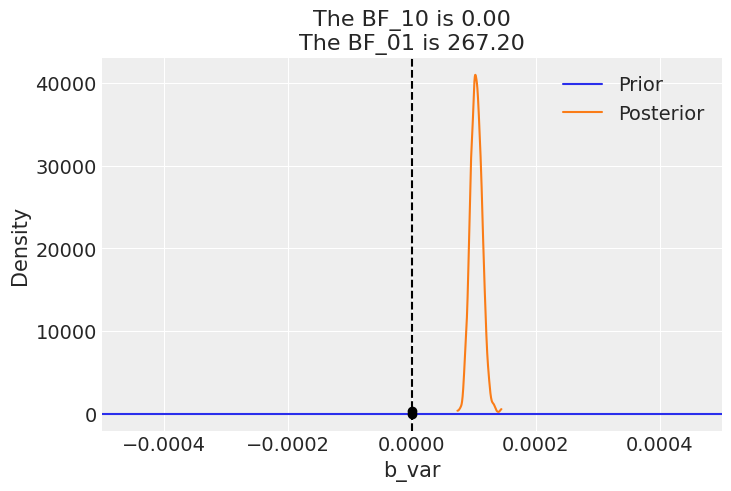

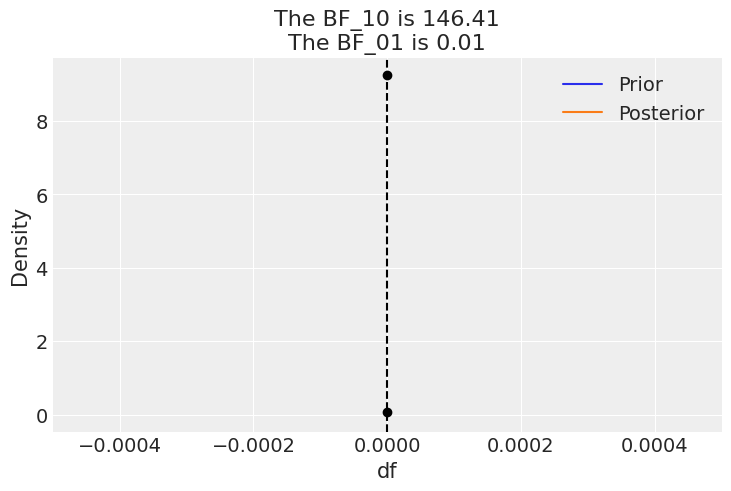

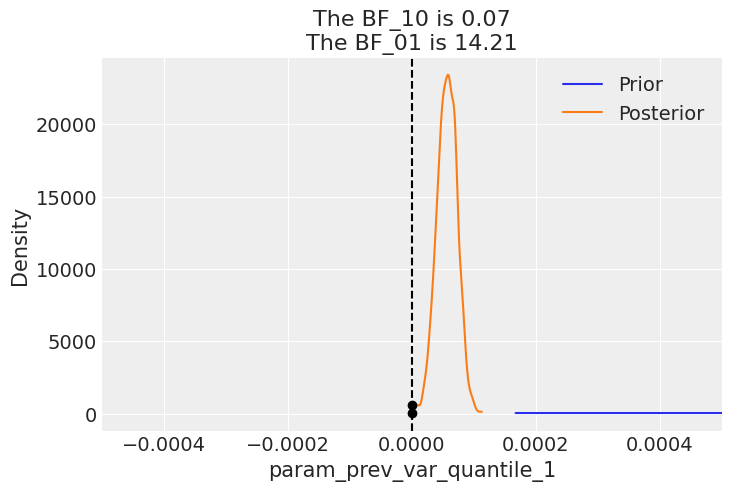

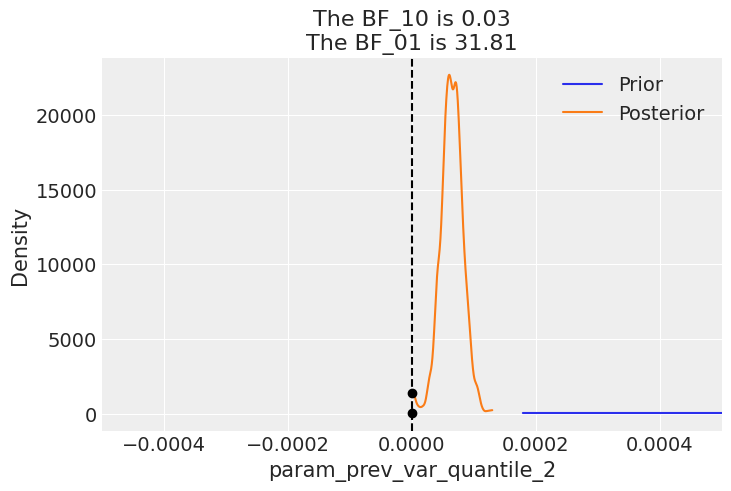

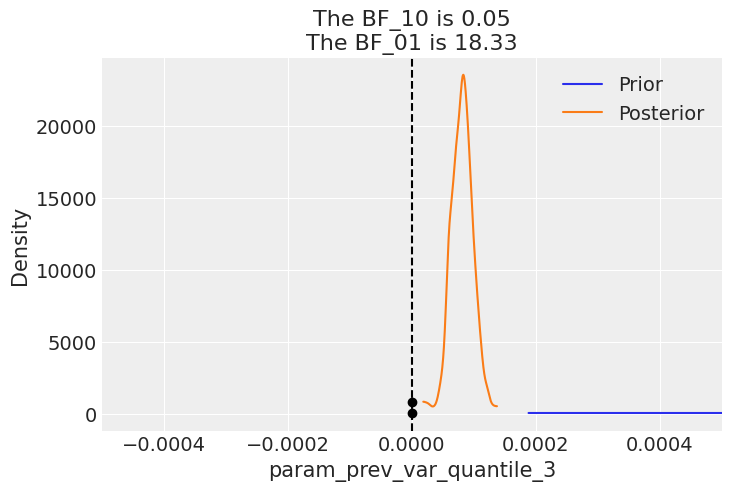

In [27]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(
    garch_like_model,
    posterior_samples=posterior_samples,
    return_sites=["log_ret"],  # or whatever your observation site is called
)
rng_key, rng_key_ppc = random.split(rng_key)
ppc_samples = predictive(
    rng_key_ppc, present_value=present_value_train, past_values=past_values_train
)
prior_samples = Predictive(garch_like_model, num_samples=2000)(
    rng_key,
    present_value=present_value_train,
    past_values=past_values_train,
)

idata = az.from_numpyro(mcmc, posterior_predictive=ppc_samples, prior=prior_samples)
for k in posterior_samples.keys():
    az.plot_bf(idata, var_name=k)
    plt.gca().set_xlim([-0.0005, 0.0005])

The model seems to be converging well(notice the $\hat{r}$). Now let’s explore basic diagnostics for the model. Starting with the forest plot of the posterior. I can immediately notice two interesting things: both biases for log return and variance are 0. Also, all variance terms except for the previous one are essentially 0 too, meaning that only the variance of the previous 3 days is important. We might very well have selected a bad time frame and we need to experiment with shorter/longer variance aggregation time frames. There is a need to study volatility clustering patterns somehow.

Note, how the estimated coefficients values are really small. This is not very surprising, since normally, the variance values are quite small, so past values the actual noisy measurements of variance need to be scaled appropriately to come with a good value for new volatility.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

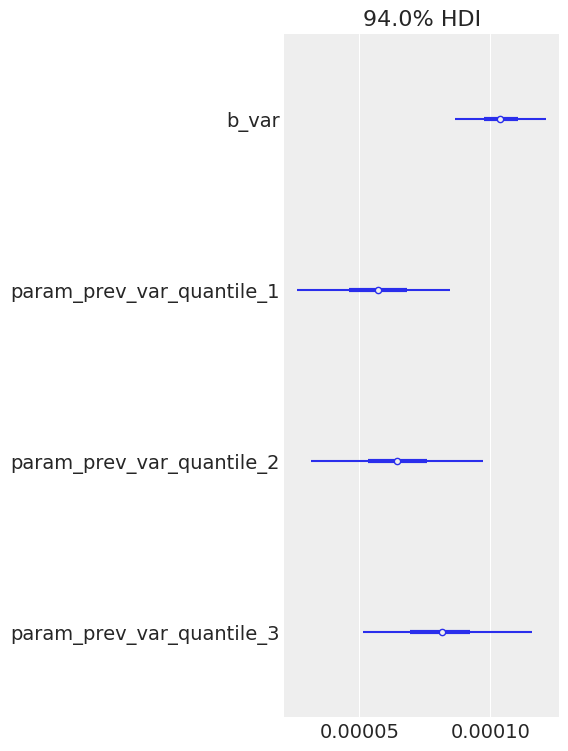

In [28]:
az.plot_forest(posterior_samples, var_names=["~df"])

Let's plot the HMC chains too, which all look adequate and as if sampling happens with high efficiency. The only odd chain is for the second lag of the variance, but that coefficient is estimated to be 0, which is consistent with higher order lags, so it seems like it can be safely ignored. 

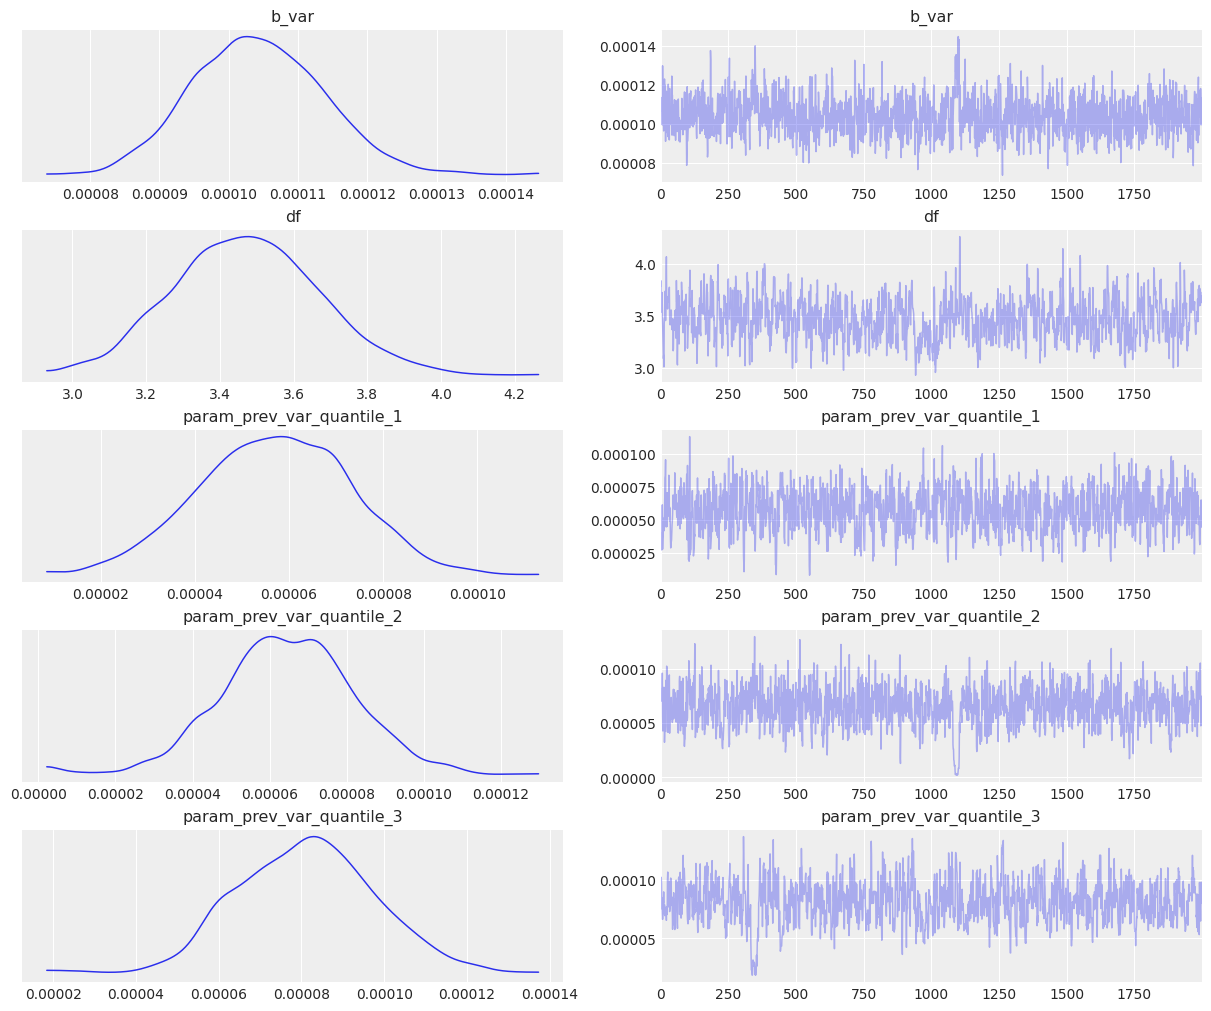

In [29]:
az.plot_trace(idata);

Finally ready to generate some paths for the oil prices. This is a simple autoregressive loop wherein the newly generated data is fed as input into the next step.

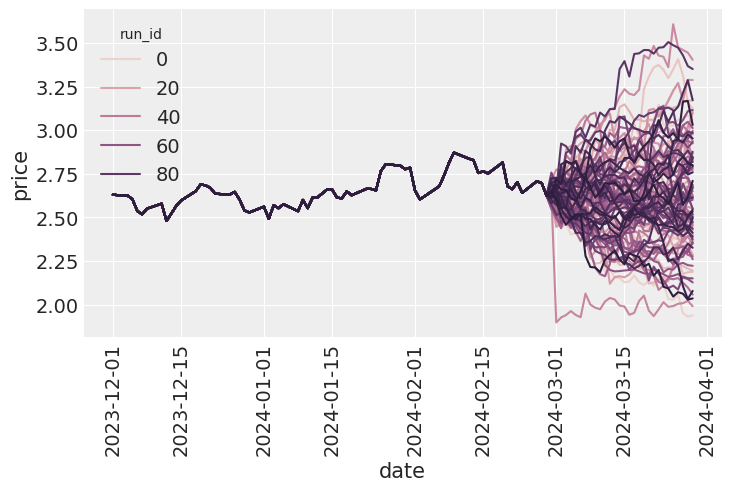

In [30]:
simulator = Simulator(
    model=garch_like_model,
    feature_engineer=feature_engineer,
)
posterior_for_gen = {k: ps[0:1] for k, ps in posterior_samples.items()}
starting_sim_df = source_df[-T - feature_engineer.n_shifts * 5 - 50 : -T]
all_runs = simulator.simulate_paths(
    steps=30,
    starting_sim_df=starting_sim_df,
    posterior_samples=posterior_for_gen,
    num_sims=100,
)
sns.lineplot(all_runs, x="date", y="price", hue="run_id")
plt.xticks(rotation=90);

As we can see on the charts below, the generated paths exhibit generally adequate behavior. Very few paths deviate and end up too high, and there is no degenerate behaviour with negative prices or prices near 0. While negative prices did happen in 2022 for oil, that is not typical and not something one could reasonably predict.

I now turn my attention to looking at the distribution for the final prices among the generated paths. We can see a somewhat healthy asymmetric distribution with a few high price examples on the right hand side. We can clearly see that the paths generated show there is some reasonable expected price behavior.

## Some backtesting

I now turn my attention to testing the predictive power of the model. Posterior checks are good and fun, but the model is autoregressive in nature, so what needs to happen is we need to roll through out test set, simulate a distribution of forward looking prices, then do boxplots, with the predicted price distributions and the actual price inside those boxes. The purpose of this exercise is to see if the actual price tends to be within the range of prices that comes out of simulations. 

In a no volatility perfectly almost perfectly predictable world, the boxes would be very tight around the actual observations, but realistically there is going to be a lot of wiggle room inside.

In [31]:
target_window = 30
simulator = Simulator(model=garch_like_model, feature_engineer=feature_engineer)
posterior_for_gen = {k: ps[0:1] for k, ps in posterior_samples.items()}
shifts = list(range(0, T, 10))
all_lasts = []
actual_prices = []
for ct, t in tqdm(enumerate(shifts), total=len(shifts)):
    # print(f"Simulating shift {ct}/{len(shifts)}")
    starting_sim_df = source_df[-T - feature_engineer.n_shifts * 5 - 50 + t : -T + t]
    this_sim = simulator.simulate_paths(
        steps=target_window,
        starting_sim_df=starting_sim_df,
        posterior_samples=posterior_for_gen,
        num_sims=50,
    )
    last_prices = (
        this_sim.sort("date")  # Ensure dates are in correct order
        .group_by("run_id")
        .agg(pl.col("price").last())  # Get the last price for each run
        .rename({"price": "final_price"})
        .with_columns(pl.lit(ct).alias("run_id"))
    )
    actual_prices.append({"run_id": ct, "actual_price": source_df[-T + t]["price"][0]})
    all_lasts.append(last_prices)
all_lasts = pl.concat(all_lasts)
actual_prices = pl.DataFrame(actual_prices)

100%|██████████| 30/30 [01:36<00:00,  3.23s/it]


<Axes: xlabel='run_id', ylabel='final_price'>

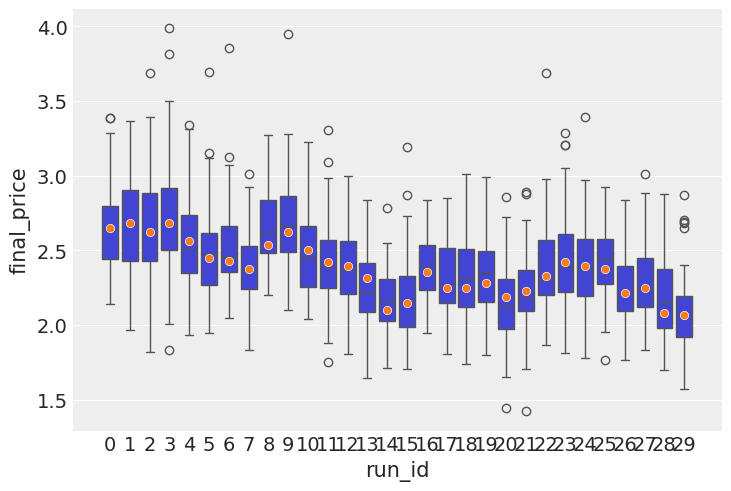

In [32]:
sns.boxplot(data=all_lasts, x="run_id", y="final_price")
sns.scatterplot(data=actual_prices, x="run_id", y="actual_price", zorder=10)
# plt.ylim([0, 200])

Calculate average deviation from target

In [38]:
all_lasts.join(
    actual_prices, left_on="run_id", right_on="run_id", how="left"
).with_columns(error=(pl.col("final_price") - pl.col("actual_price")) ** 2).group_by(
    "run_id"
).agg(pl.col("error").mean())["error"].mean()

0.0889535895549873

<Axes: xlabel='final_price', ylabel='Count'>

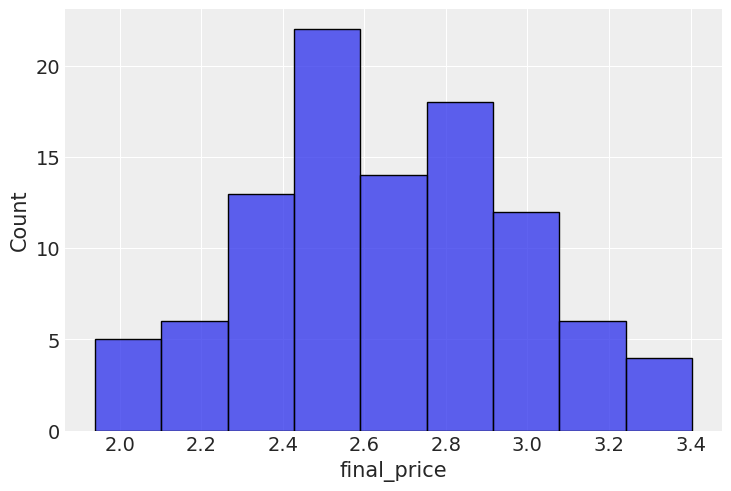

In [33]:
last_prices = (
    all_runs.sort("date")  # Ensure dates are in correct order
    .group_by("run_id")
    .agg(pl.col("price").last())  # Get the last price for each run
    .rename({"price": "final_price"})
)
sns.histplot(last_prices, x="final_price")

Next, we calculate the call option payoff distributions, as well as model-implied option prices.

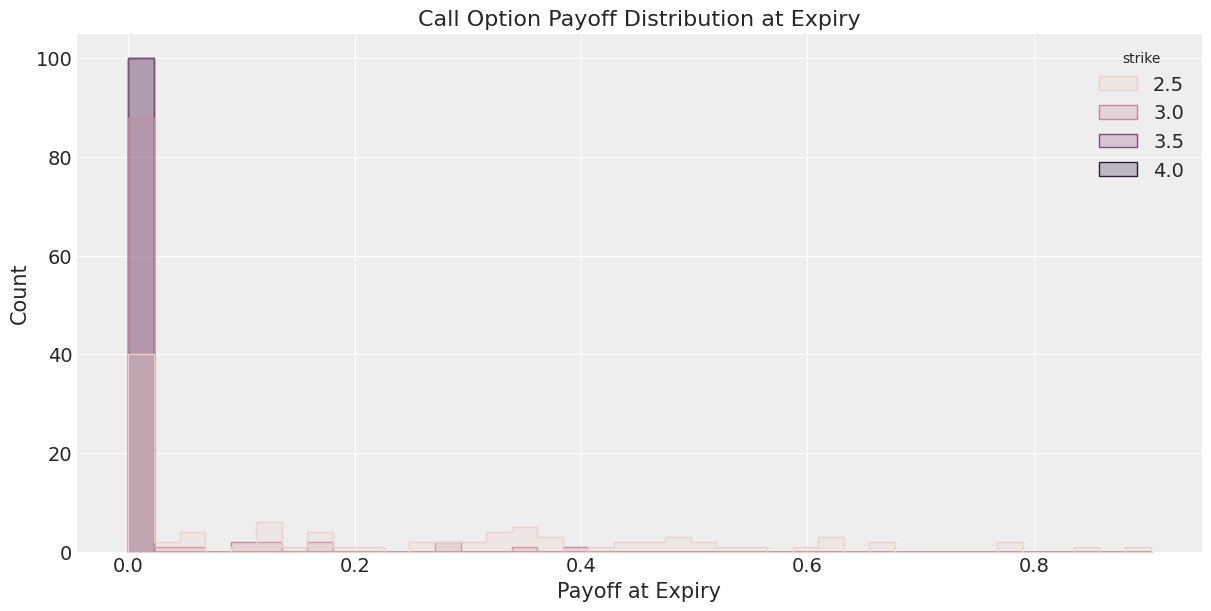

In [34]:
strike_prices = [2.5, 3.0, 3.5, 4.0]

# Create a list of DataFrames, one per strike
payoff_dfs = [
    last_prices.with_columns(
        payoff_at_expiry=(pl.col("final_price") - strike).clip(0),
        strike=pl.lit(strike),  # so we can track which row belongs to which strike
    )
    for strike in strike_prices
]

# Concatenate into one big DataFrame
payoff_df_all = pl.concat(payoff_dfs)
plt.figure(figsize=(12, 6))
sns.histplot(
    data=payoff_df_all,
    x="payoff_at_expiry",
    hue="strike",
    element="step",
    stat="count",
    bins=40,
)
plt.title("Call Option Payoff Distribution at Expiry")
plt.xlabel("Payoff at Expiry")
plt.ylabel("Count")
plt.grid(True)
plt.show()

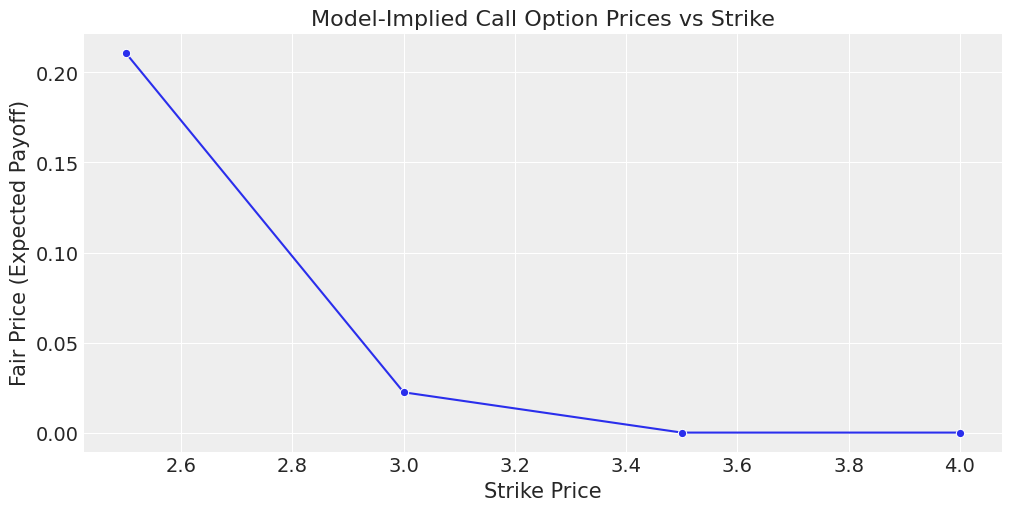

In [35]:
# Group and average payoff per strike
implied_prices = payoff_df_all.group_by("strike").agg(pl.col("payoff_at_expiry").mean())

# Plot the pricing curve
plt.figure(figsize=(10, 5))
sns.lineplot(data=implied_prices, x="strike", y="payoff_at_expiry", marker="o")
plt.title("Model-Implied Call Option Prices vs Strike")
plt.xlabel("Strike Price")
plt.ylabel("Fair Price (Expected Payoff)")
plt.grid(True)
plt.show()

This wraps up my initial attempt at a generative, volatility-aware option pricing framework. There’s more work to be done—especially around incorporating latent volatility, or testing market-implied vol surfaces—but even this simplified model gives useful directional insight. Overall, this project was a small but useful step toward building generative models that respect volatility dynamics, rather than assuming them away.There’s a long road between reasonable simulations and production-grade financial modeling, but this framework makes experimentation straightforward—which is exactly the point. Of course, this is an extremely simplified toy model and not meant for real-world trading or production.